# depending on env - install libraries & set paths

In [1]:
import sys

def check_environment():
    if 'google.colab' in sys.modules:
        # Running in Google Colab
        return "Google Colab"
    
    if hasattr(sys, 'prefix'):
        if sys.prefix.startswith('/usr/local'):
            # Running in a Colab-like environment (could be Colab or another cloud environment)
            return "Colab-like environment"
        else:
            # Running in a local environment
            return "Local environment"
    
    # Default to local environment if checks are inconclusive
    return "Local environment"

In [2]:
# set paths and install packages depending on the environment

if check_environment() == 'Google Colab':
    !pip install transformers torch bertopic openai natasha

    from google.colab import drive
    drive.mount('/content/drive')

    data_path = '/content/drive/MyDrive/Colab Notebooks/TG news channels/'
    result_path = '/content/drive/MyDrive/Colab Notebooks/TG news channels/df_4_dashboard/'

else:
    data_path = '/Users/alexbadin/Library/CloudStorage/GoogleDrive-alex.badin@gmail.com/My Drive/Colab Notebooks/Narratives/TG news channels/'
    result_path = '/Users/alexbadin/Library/CloudStorage/GoogleDrive-alex.badin@gmail.com/My Drive/Colab Notebooks/Narratives/TG news channels/df_4_dashboard/'

In [3]:
# list only csv-files in the results folder
import os
for file in os.listdir(result_path):
    if file.endswith('.csv'):
        print(file)

df_cluster_names.csv
df_cross.csv
df_ner.csv
df_narr.csv
df_text_table.csv


- df_cross.csv - overview (N of total)
- df_cluster_names.csv
- df_ner.csv
- df_narr.csv
- df_text_table.csv

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

## Open 5 dashboard df's + sources_type

In [13]:
# open csv-files into respective dataframes
df_sources_types = pd.read_csv(data_path+'/channels.csv', sep=';')
df_narr = pd.read_csv(result_path+'df_narr.csv')
df_ner = pd.read_csv(result_path+'df_ner.csv')
df_cluster_names = pd.read_csv(result_path+'df_cluster_names.csv')
df_text_table = pd.read_csv(result_path+'df_text_table.csv')
df_cross = pd.read_csv(result_path+'df_cross.csv')

# print columns of dataframes
print("df_cluster_names columns:", df_cluster_names.columns)
print("df_cross columns:", df_cross.columns)
print("df_ner columns:", df_ner.columns)
print("df_narr columns:", df_narr.columns)
print("df_text_table columns:", df_text_table.columns)
print("df_sources_types columns:", df_sources_types.columns)

df_cluster_names columns: Index(['topic', 'cluster_name'], dtype='object')
df_cross columns: Index(['date', 'channel_name', 'cleaned_message_all', 'views_all',
       'cleaned_message_filtered', 'views_filtered', 'channel_code',
       'media_type', 'content_type', 'audience size', 'share_filtered',
       'share_views_filtered'],
      dtype='object')
df_ner columns: Index(['entity', 'type', 'msg_id', 'channel_name'], dtype='object')
df_narr columns: Index(['msg_id', 'narr', 'pred', 'channel_name'], dtype='object')
df_text_table columns: Index(['channel_name', 'msg_id', 'cleaned_message', 'date', 'topic', 'views',
       'number_forwards'],
      dtype='object')
df_sources_types columns: Index(['link', 'channel_name', 'channel_code', 'last_id', 'ignore',
       'media_type', 'website', 'content_type', 'audience size'],
      dtype='object')


In [8]:
df_narr

,msg_id,narr,pred,channel_name
0,23391,ВСУ отступают,0.659981,rusvesnasu
1,178301,Бойцы Вагнер совершают преступления,0.553433,tass_agency
2,176868,ВСУ отступают,0.801588,tass_agency
3,166260,ВСУ отступают,0.734203,tass_agency
4,103029,ВСУ отступают,0.888649,ntvnews
...,...,...,...,...
157,27491,Бойцы Вагнер совершают преступления,0.772842,voenacher
158,10464,ВСУ отступают,0.965372,vysokygovorit
159,10443,Бойцы Вагнер совершают преступления,0.549109,vysokygovorit
160,9792,Бойцы Вагнер совершают преступления,0.713993,vysokygovorit


## adjust types of sources -> stance

In [15]:
pd.crosstab(df_sources_types['media_type'], df_sources_types['content_type'])


content_type,altern,moder,propaganda,voenkor
media_type,,,,
tg - news,1,1,1,0
tg - pers,0,0,2,6
tv,0,0,6,0
web/press,8,7,16,0


required list of stance:
- TV (media_type=tv)
- inet propaganda
- moder 
- voenkor
- altern


In [16]:
# new variable as per the list above
df_sources_types['stance'] = df_sources_types['content_type']
df_sources_types.loc[df_sources_types['media_type'] == 'tv', 'stance'] = 'tv'
# rename 'propaganda'
df_sources_types['stance'] = df_sources_types['stance'].replace('propaganda', 'inet propaganda')
df_sources_types.stance.value_counts()

stance
inet propaganda    19
altern              9
moder               8
tv                  6
voenkor             6
Name: count, dtype: int64

In [167]:
df_sources_types

,link,channel_name,channel_code,last_id,ignore,media_type,website,content_type,audience size,stance
0,https://t.me/rt_russian,rt_russian,RT,164235,NaN,tv,rt.com,propaganda,105.0,tv
1,https://t.me/ntvnews,ntvnews,NTV,116705,NaN,tv,ntv.ru,propaganda,NaN,tv
2,https://t.me/tvrussia1,tvrussia1,ROS1,19538,NaN,tv,NaN,propaganda,NaN,tv
3,https://t.me/bbcrussian,bbcrussian,BBCR,48798,NaN,web/press,https://www.bbc.com/russian,altern,NaN,altern
4,https://t.me/news_1tv,news_1tv,1TV,22056,NaN,tv,1tv.ru,propaganda,NaN,tv
5,https://t.me/redakciya_channel,redakciya_channel,RDKC,21152,NaN,tg - news,https://www.youtube.com/channel/UC1eFXmJNkjITx...,altern,NaN,altern
6,https://t.me/meduzalive,meduzalive,MEDZ,87152,NaN,web/press,meduza.io,altern,NaN,altern
7,https://t.me/mediazzzona,mediazzzona,MDZN,12101,NaN,web/press,zona.media,altern,NaN,altern
8,https://t.me/thebell_io,thebell_io,BELL,23585,NaN,web/press,thebell.io,altern,NaN,altern
9,https://t.me/rian_ru,rian_ru,RIA,207734,NaN,web/press,ria.ru,propaganda,153.0,inet propaganda


# Theme presence in dynamics

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df_cross = pd.read_csv(result_path+'df_cross.csv')
df_cross.head(2)

,date,channel_name,cleaned_message_all,views_all,cleaned_message_filtered,views_filtered,channel_code,media_type,content_type,audience size,share_filtered,share_views_filtered
0,2022-08-01,BFMnews,2.0,25773.0,0.0,0.0,BFM,web/press,moder,7.0,0.0,0.0
1,2022-08-02,BFMnews,3.0,39271.0,0.0,0.0,BFM,web/press,moder,7.0,0.0,0.0


### share of theme vs stance

In [51]:
df_share_by_stance = df_cross.groupby(['stance'])[['cleaned_message_all','cleaned_message_filtered']].sum()
df_share_by_stance.loc['ALL'] = df_share_by_stance.sum()
df_share_by_stance['share'] = round((df_share_by_stance['cleaned_message_filtered'] / df_share_by_stance['cleaned_message_all'] * 100), 2)
df_share_by_stance = df_share_by_stance.sort_values(by='share', ascending=False)
df_share_by_stance

,cleaned_message_all,cleaned_message_filtered,share
stance,,,
voenkor,2684.0,159.0,5.92
altern,5633.0,171.0,3.04
ALL,33220.0,700.0,2.11
inet propaganda,17150.0,261.0,1.52
moder,3054.0,43.0,1.41
tv,4699.0,66.0,1.40


Text(0.5, 1.0, 'Share of filtered messages by stance')

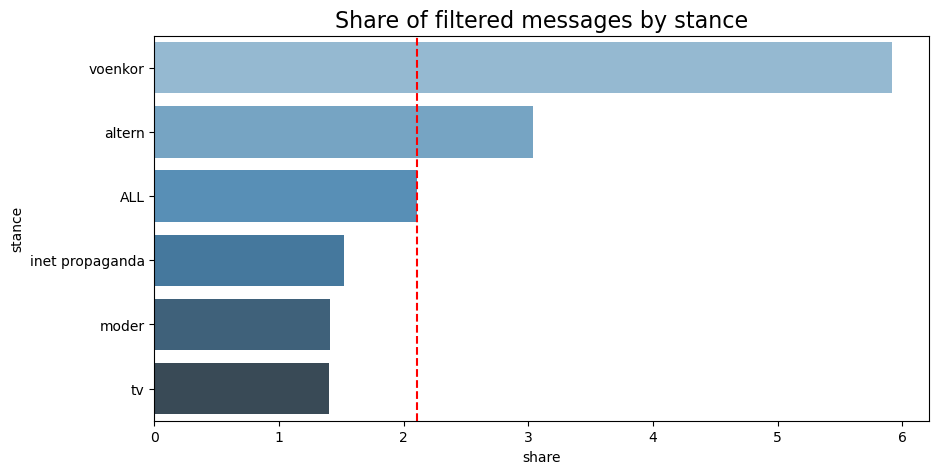

In [52]:
# chart share by stance: horizontal bar chart; draw average line (which euqals to ALL)
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='share', y=df_share_by_stance.index, data=df_share_by_stance, palette='Blues_d')
ax.axvline(df_share_by_stance.loc['ALL', 'share'], color='red', linestyle='--')
ax.set_title('Share of filtered messages by stance, %', fontsize=16) 

In [19]:
# convert to date
df_cross.date = pd.to_datetime(df_cross.date, format='%Y-%m-%d')

In [20]:
df_cross.date.min(), df_cross.date.max()

(Timestamp('2022-08-01 00:00:00'), Timestamp('2023-01-31 00:00:00'))

In [21]:
# remove dates as per filter used
df_cross = df_cross[df_cross.date > '2022-10-01']

In [22]:
# add to df_cross stance from df_sources_types
df_cross = df_cross.merge(df_sources_types[['channel_name', 'stance']], on='channel_name', how='left')

In [23]:
# add week number with year
df_cross['week'] = df_cross.date.dt.isocalendar().year.astype(str) + '-' + df_cross.date.dt.isocalendar().week.astype(str)

Text(0.5, 1.0, 'Weekly messages by stance')

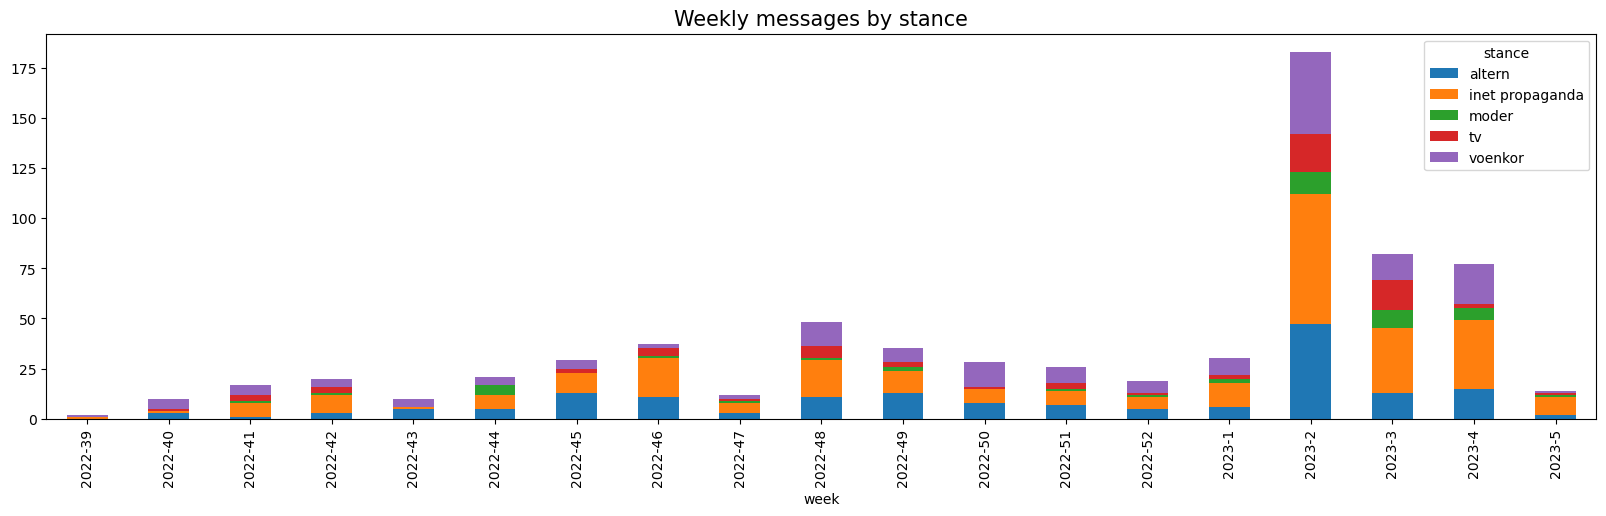

In [24]:
df_cross_weekly = df_cross.groupby(['week', 'stance']).agg({'cleaned_message_filtered': 'sum','cleaned_message_all': 'sum'})
df_cross_weekly['cleaned_message_filtered'].unstack().plot(kind='bar', stacked=True, figsize=(20,5))
# title 
plt.title('Weekly messages by stance', fontsize=15)

Text(0.5, 1.0, 'Share of filtered messages by stance per week (from all news)')

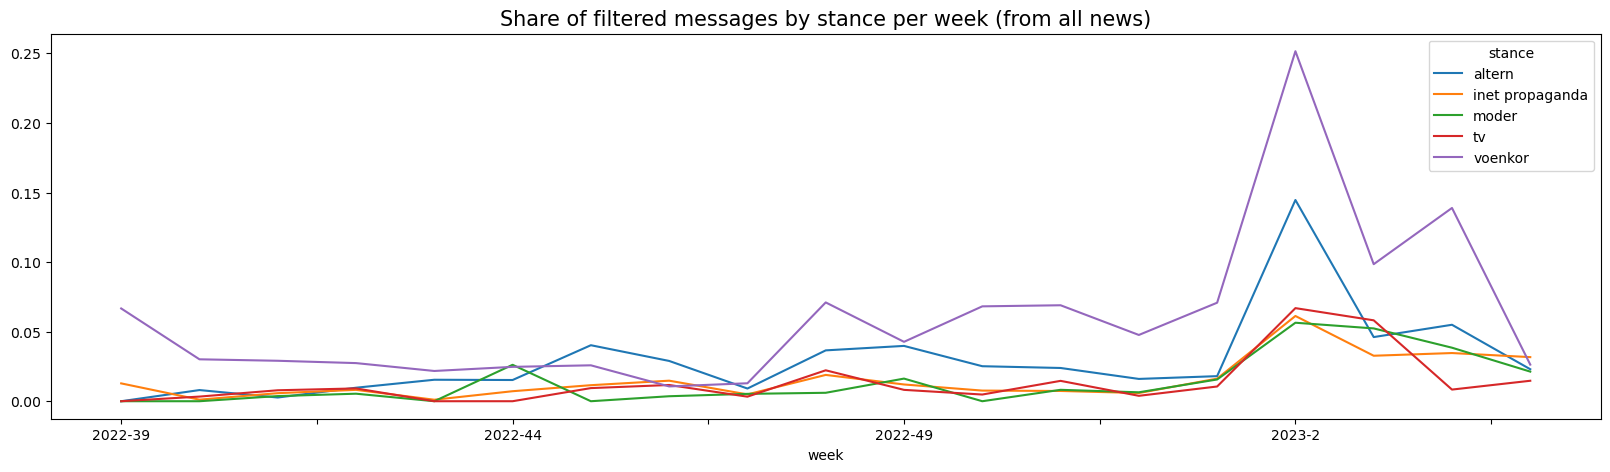

In [25]:
# recalc share_filtered as cleaned_message_filtered / cleaned_message_all per weeks
df_cross_weekly['share_filtered'] = df_cross_weekly['cleaned_message_filtered'] / df_cross_weekly['cleaned_message_all']
# line chart for share_filtered
df_cross_weekly['share_filtered'].unstack().plot(kind='line', figsize=(20,5))
# title
plt.title('Share of filtered messages by stance per week (from all news)', fontsize=15)

Determine outliers (when theme was much more / less popular) => news clusters in peak vs other periods. 

# Differences across stance

In [26]:
df_text_table = pd.read_csv(result_path+'df_text_table.csv')
df_text_table.shape

(798, 7)

In [27]:
# align name with other dataframes
df_text_table.rename(columns={'author': 'channel_name'}, inplace=True)

In [28]:
# add stance from df_sources_types
df_text_table = df_text_table.merge(df_sources_types[['channel_name', 'stance']], on='channel_name', how='left')

## topic clusters

In [29]:
cross_stance_clust = pd.crosstab(df_text_table['stance'], df_text_table['topic'])

topic,-1,0,1,2,3,4
stance,,,,,,
altern,114,5,18,0,37,9
inet propaganda,152,84,31,13,6,8
moder,30,6,2,0,2,5
tv,37,25,1,1,3,3
voenkor,107,19,23,52,4,1


In [146]:
cross_stance_clust = round(pd.crosstab(df_text_table['stance'], df_text_table['topic'], normalize='index')*100, 1)
cross_stance_clust

topic,-1,0,1,2,3,4
stance,,,,,,
altern,62.3,2.7,9.8,0.0,20.2,4.9
inet propaganda,51.7,28.6,10.5,4.4,2.0,2.7
moder,66.7,13.3,4.4,0.0,4.4,11.1
tv,52.9,35.7,1.4,1.4,4.3,4.3
voenkor,51.9,9.2,11.2,25.2,1.9,0.5


<Axes: xlabel='topic', ylabel='stance'>

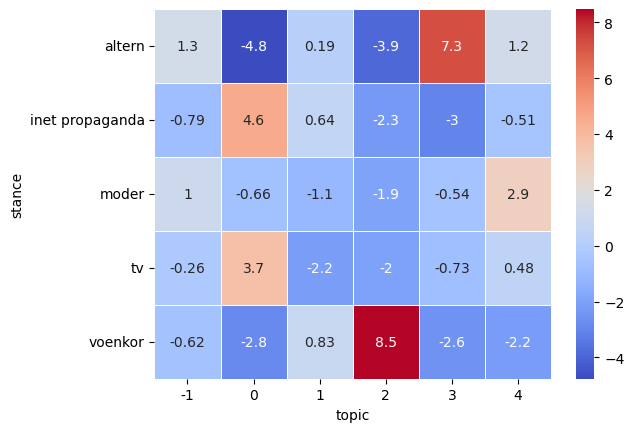

In [57]:
from scipy.stats import chi2_contingency

# create the contingency table
contingency_table = pd.crosstab(df_text_table['stance'], df_text_table['topic'])

# calculate the chi2 statistic and p-value
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# calculate the residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

residuals_orig = residuals.copy()

# print(residuals)
# heatmap
sns.heatmap(residuals, annot=True, cmap='coolwarm', linewidths=0.5)

In [58]:
residuals_sign = pd.DataFrame(np.where(residuals_orig > 2, '+', np.where(residuals_orig < -2, '-', '')), index=contingency_table.index, columns=contingency_table.columns)
print(residuals_sign)

topic           -1  0  1  2  3  4
stance                           
altern              -     -  +   
inet propaganda     +     -  -   
moder                           +
tv                  +  -         
voenkor             -     +  -  -


In [59]:
# columns with + and - signs
cols_sign = residuals_sign.columns[residuals_sign.isin(['+', '-']).any()]

# keep only columns with significances
residuals = residuals_org.loc[:, cols_sign]

# add topic names to residuals from df_cluster_names
residuals = residuals.T.merge(df_cluster_names[['topic', 'cluster_name']], on='topic', how='left').drop('topic', axis=1).T
# replace columns names with cluster_name
residuals.columns = residuals.T.cluster_name
# remove cluster_name row
residuals = residuals.drop('cluster_name', axis=0)


In [60]:
# sns.heatmap(residuals, annot=True, cmap='coolwarm', linewidths=0.5)
residuals.T

,altern,inet propaganda,moder,tv,voenkor
cluster_name,,,,,
"""Вагнеровцы"" активно действуют на юге Артемовска, наносят ущерб украинским силам.",-4.760276,4.581997,-0.656621,3.667693,-2.818316
"""Российские войска ведут активные боевые действия на Украине, контролируют Соледар.""",0.193083,0.640802,-1.084021,-2.175074,0.827048
"""Совместные силы и ЧВК «Вагнер» продолжают бои за Бахмут и Соледар в 2022 - 2023 годах.""",-3.890416,-2.294778,-1.929198,-1.990528,8.470269
"Дискуссии о случаях жестокого обращения ЧВК ""Вагнер"" с бывшими заключенными и пленными в Украине.",7.261368,-3.006163,-0.544457,-0.731082,-2.57206
"""США накладывают санкции на Россию, обсуждения внутри страны возрастают, напряжение сохраняется.""",1.243996,-0.510163,2.918467,0.476294,-2.204716


In [153]:
# combine values from residuals and cross_stance_clust
cross_stance_clust1 = cross_stance_clust.astype(str) + " " + residuals_sign.astype(str)
cross_stance_clust1

topic,-1,0,1,2,3,4
stance,,,,,,
altern,62.3,2.7 -,9.8,0.0 -,20.2 +,4.9
inet propaganda,51.7,28.6 +,10.5,4.4 -,2.0 -,2.7
moder,66.7,13.3,4.4,0.0,4.4,11.1 +
tv,52.9,35.7 +,1.4 -,1.4,4.3,4.3
voenkor,51.9,9.2 -,11.2,25.2 +,1.9 -,0.5 -


In [154]:
cross_stance_clust1 = cross_stance_clust1.loc[:, cols_sign]
cross_stance_clust1 = cross_stance_clust1.T.merge(df_cluster_names[['topic', 'cluster_name']], on='topic', how='left').drop('topic', axis=1).T
cross_stance_clust1.columns = cross_stance_clust1.T.cluster_name
cross_stance_clust1 = cross_stance_clust1.drop('cluster_name', axis=0)

In [156]:
cross_stance_clust1.T

,altern,inet propaganda,moder,tv,voenkor
cluster_name,,,,,
"""Вагнеровцы"" активно действуют на юге Артемовска, наносят ущерб украинским силам.",2.7 -,28.6 +,13.3,35.7 +,9.2 -
"""Российские войска ведут активные боевые действия на Украине, контролируют Соледар.""",9.8,10.5,4.4,1.4 -,11.2
"""Совместные силы и ЧВК «Вагнер» продолжают бои за Бахмут и Соледар в 2022 - 2023 годах.""",0.0 -,4.4 -,0.0,1.4,25.2 +
"Дискуссии о случаях жестокого обращения ЧВК ""Вагнер"" с бывшими заключенными и пленными в Украине.",20.2 +,2.0 -,4.4,4.3,1.9 -
"""США накладывают санкции на Россию, обсуждения внутри страны возрастают, напряжение сохраняется.""",4.9,2.7,11.1 +,4.3,0.5 -


## NER

In [65]:
# add stance from df_sources_types
df_ner = df_ner.merge(df_sources_types[['channel_name', 'stance']], on='channel_name', how='left')
df_ner.head(2)

,entity,type,msg_id,channel_name,stance
0,МВД,ORG,24458,rusvesnasu,inet propaganda
1,Залужный,PER,24458,rusvesnasu,inet propaganda


In [102]:
# need aggregated dataframe with columns: entity, stance and total number of messages in stance
df_ner_agg = df_ner.groupby(['stance', 'type', 'entity'])['entity'].count().sort_values(ascending=False).reset_index(name='count')
# add total number of messages in stance
df_ner_agg['total_by_stance'] = df_ner_agg.stance.map(df_share_by_stance.cleaned_message_filtered)
df_ner_agg['share_in_stance'] = round(df_ner_agg['count'] / df_ner_agg['total_by_stance'] * 100, 2)
df_ner_agg

,stance,type,entity,count,total_by_stance,share_in_stance
0,inet propaganda,ORG,Вагнер,191,261.0,73.18
1,inet propaganda,ORG,ЧВК,187,261.0,71.65
2,inet propaganda,ORG,ВСУ,147,261.0,56.32
3,voenkor,ORG,ВСУ,146,159.0,91.82
4,voenkor,ORG,ЧВК,135,159.0,84.91
...,...,...,...,...,...,...
2178,inet propaganda,ORG,The Times,1,261.0,0.38
2179,inet propaganda,ORG,Telegram-канала Astra Militarum,1,261.0,0.38
2180,inet propaganda,ORG,Spiegel,1,261.0,0.38
2181,inet propaganda,ORG,Sladkov_plus,1,261.0,0.38


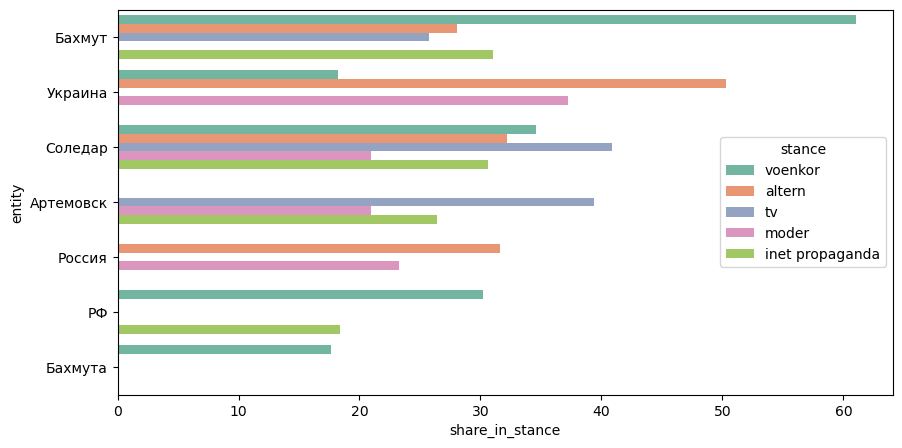

In [124]:
# top entities by stance
# stance = ['inet propaganda', 'tv'] 
stance = df_ner.stance.unique()
ner_type = ['LOC']
# ner_type = df_ner.type.unique()
top_n = 20

df_ner_agg_plt = df_ner_agg[(df_ner_agg.stance.isin(stance)) & (df_ner_agg.type.isin(ner_type))].sort_values(by='share_in_stance', ascending=False).head(top_n)

# plot top entities by stance
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='share_in_stance', y='entity', hue='stance', data=df_ner_agg_plt, palette='Set2')

need manual corrections (or AI can check):
- combine name+surname & surname
- misclassifications

### Correspondence Analysis

In [ ]:
import prince

: 

In [ ]:
pca = prince.PCA(n_components=2)

: 

## Narratives

In [159]:
# add stance from df_sources_types
df_narr = pd.read_csv(result_path+'df_narr.csv')
df_narr = df_narr.merge(df_sources_types[['channel_name', 'stance']], on='channel_name', how='left')
df_narr.head(2)

,msg_id,narr,pred,channel_name,stance
0,23391,ВСУ отступают,0.659981,rusvesnasu,inet propaganda
1,178301,Бойцы Вагнер совершают преступления,0.553433,tass_agency,inet propaganda


In [161]:
pd.crosstab(df_narr['narr'], df_narr['stance'])

stance,altern,inet propaganda,moder,tv,voenkor
narr,,,,,
Бойцы Вагнер совершают преступления,12,40,2,7,26
ВСУ отступают,8,34,5,9,19


In [164]:
# need aggregated dataframe with columns: narr, stance and total number of messages in stance
df_narr_agg = df_narr.groupby(['stance', 'narr'])['narr'].count().sort_values(ascending=False).reset_index(name='count')
# add total number of messages in stance
df_narr_agg['total_by_stance'] = df_narr_agg.stance.map(df_share_by_stance.cleaned_message_filtered)
df_narr_agg['share_in_stance'] = round(df_narr_agg['count'] / df_narr_agg['total_by_stance'] * 100, 2)
df_narr_agg

,stance,narr,count,total_by_stance,share_in_stance
0,inet propaganda,Бойцы Вагнер совершают преступления,40,261.0,15.33
1,inet propaganda,ВСУ отступают,34,261.0,13.03
2,voenkor,Бойцы Вагнер совершают преступления,26,159.0,16.35
3,voenkor,ВСУ отступают,19,159.0,11.95
4,altern,Бойцы Вагнер совершают преступления,12,171.0,7.02
5,tv,ВСУ отступают,9,66.0,13.64
6,altern,ВСУ отступают,8,171.0,4.68
7,tv,Бойцы Вагнер совершают преступления,7,66.0,10.61
8,moder,ВСУ отступают,5,43.0,11.63
9,moder,Бойцы Вагнер совершают преступления,2,43.0,4.65


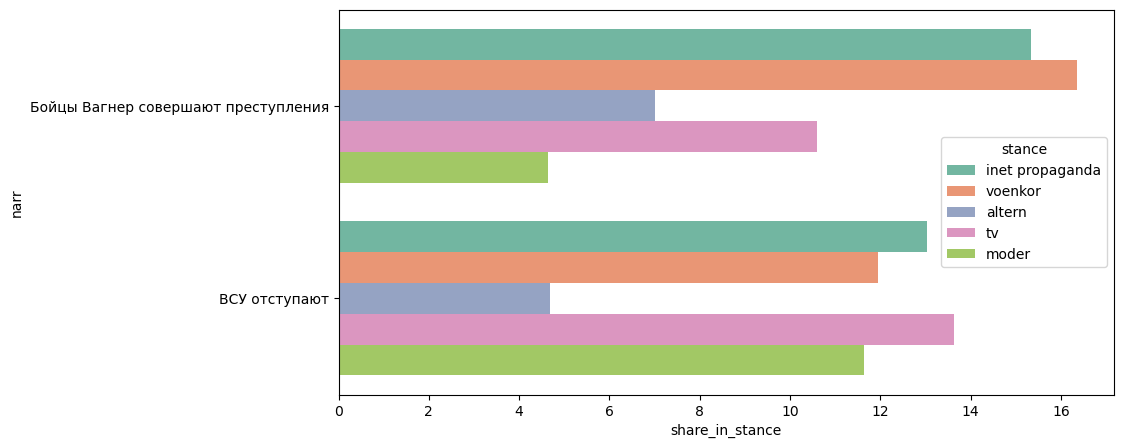

In [166]:
# plot top entities by stance
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='share_in_stance', y='narr', hue='stance', data=df_narr_agg, palette='Set2')

# Dynamics

## Clusters

## Narratives